In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import preprocessor as p
import re
import numpy as np
import warnings

pd.set_option('display.max_colwidth', None)
tqdm.pandas()
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
all_files = []
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)

In [3]:
tmp_df_list = []
for file in all_files:
    print(f"Reading in {file}")
    tmp_df = pd.read_csv(file)
    print(f"\t{len(tmp_df)} entries")
    tmp_df_list.append(tmp_df)

print("Concatenating the DataFrames")
data = pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Reading in data/Russian_border_Ukraine.csv
	53040 entries
Reading in data/Russian_troops.csv
	128405 entries
Reading in data/Russia_invade.csv
	170835 entries
Reading in data/StandWithUkraine.csv
	148145 entries
Reading in data/Ukraine_border.csv
	166610 entries
Reading in data/Ukraine_nato.csv
	245232 entries
Reading in data/Ukraine_troops.csv
	172714 entries
Reading in data/Ukraine_war.csv
	231624 entries
Concatenating the DataFrames
Concatenation complete!


In [ ]:
# data = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/war_data/Russian_border_Ukraine.csv')
print(data.info(max_cols=29))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1316605 entries, 0 to 231623
Data columns (total 29 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   _type             1316605 non-null  object 
 1   url               1316605 non-null  object 
 2   date              1316605 non-null  object 
 3   content           1316605 non-null  object 
 4   renderedContent   1316605 non-null  object 
 5   id                1316605 non-null  int64  
 6   user              1316605 non-null  object 
 7   replyCount        1316605 non-null  int64  
 8   retweetCount      1316605 non-null  int64  
 9   likeCount         1316605 non-null  int64  
 10  quoteCount        1316605 non-null  int64  
 11  conversationId    1316605 non-null  int64  
 12  lang              1316605 non-null  object 
 13  source            1316605 non-null  object 
 14  sourceUrl         1316605 non-null  object 
 15  sourceLabel       1316605 non-null  object 
 16  o

In [4]:
data["date"] = pd.to_datetime(data["date"])

earliest_tweet = data["date"].min()
latest_tweet = data["date"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2021-12-31 00:00:30+00:00, and the latest was at 2022-03-05 23:59:59+00:00


In [5]:
print(f"There are {data['lang'].nunique()} unique languages in this DataFrame.")
print(data["lang"].unique())
print(f"{round(data.loc[data['lang']=='en'].shape[0]/data.shape[0]*100, 2)}% of the tweets are in English.")

There are 61 unique languages in this DataFrame.
['en' 'es' 'und' 'hi' 'in' 'de' 'ja' 'pl' 'et' 'zh' 'ro' 'nl' 'tr' 'pa'
 'da' 'pt' 'tl' 'eu' 'fr' 'no' 'cs' 'ru' 'fi' 'it' 'sv' 'ca' 'kn' 'sl'
 'ta' 'ar' 'ko' 'ur' 'bn' 'gu' 'uk' 'lv' 'ne' 'ml' 'sd' 'ht' 'cy' 'el'
 'hu' 'fa' 'lt' 'my' 'vi' 'te' 'iw' 'th' 'dv' 'ka' 'is' 'sr' 'bg' 'am'
 'mr' 'si' 'km' 'or' 'ps']
91.67% of the tweets are in English.


In [6]:
prev_size = len(data)
# drop rows with missing values in the 'renderedContent' column
data = data.dropna(subset=['renderedContent'])
# drop all rows with non english text
data = data[data['lang'] == 'en'].drop(columns=['lang'])
change = prev_size - len(data)
print(f"Dropped {change} rows")
print(f"{len(data)} entries remain")

Dropped 109620 rows
1206985 entries remain


In [8]:
prev_size = len(data)
dupe_mask = data['renderedContent'].duplicated(keep=False)
data = data[~dupe_mask]
change = prev_size - len(data)
print(f"Dropped {change} duplicated rows")
print(f"{len(data)} tweets remain in the dataset")

Dropped 406566 duplicated rows
800419 tweets remain in the dataset


In [ ]:
# Define a regular expression pattern to match hashtags
pattern = r'#(\w+)'

# Extract hashtags from the renderedContent column and concatenate them into a single list
hashtags = []
for text in data['renderedContent']:
    hashtags += re.findall(pattern, text)

# Count the frequency of each hashtag
hashtag_counts = pd.Series(hashtags).value_counts()

# Print the top 10 most common hashtags
print("Ten most common hashtags in the text:")
print(hashtag_counts.head(25))

most_common_hashtag = hashtag_counts.iloc[:25]

Ten most common hashtags in the text:
Ukraine                114895
StandWithUkraine        63357
Russia                  55317
NATO                    29862
Putin                   17162
Russian                 13652
ukraine                  8142
UkraineCrisis            6911
US                       6014
USA                      5772
RussiaUkraine            5289
Biden                    5195
UkraineRussiaWar         5146
UkraineWar               5123
russia                   4843
UkraineConflict          4756
Europe                   4568
Belarus                  4551
war                      4264
UkraineInvasion          4026
BREAKING                 3928
Kyiv                     3853
EU                       3627
RussiaUkraineCrisis      3537
news                     3188
dtype: int64


In [ ]:
# Define a regular expression pattern to match hashtags
pattern = r'@(\w+)'

# Extract hashtags from the renderedContent column and concatenate them into a single list
mentions = []
for text in data['renderedContent']:
    mentions += re.findall(pattern, text)

# Count the frequency of each mention
mention_counts = pd.Series(mentions).value_counts()

# Print the top 10 most common mentions
print("Ten most common mentions in the text:")
print(mention_counts.head(10))
most_common_mentions = mention_counts.iloc[:10]

Ten most common mentions in the text:
NATO               22099
POTUS              20818
YouTube             8637
KremlinRussia_E     7808
ZelenskyyUa         7545
McFaul              7282
Reuters             7027
SecBlinken          6604
mfa_russia          6452
Ukraine             6260
dtype: int64


In [ ]:
def remove_unnecessary(text):
    text = text.replace("\n", " ")
    text = text.replace("&amp;", " ")
    for hashtag in most_common_hashtag.keys():
        text = text.replace(f"#{hashtag}", " ".join(re.findall('[A-Z][^A-Z]*', hashtag)))
    for mention in most_common_mentions.keys():
        text = text.replace(f'@{mention}', mention)
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.NUMBER, p.OPT.EMOJI, p.OPT.SMILEY)
    result = p.clean(text)
    return result

data["cleanedTweet"] = data["renderedContent"].progress_map(remove_unnecessary)

100%|██████████| 1206985/1206985 [14:47<00:00, 1359.46it/s] 


In [ ]:
prev_size = len(data)
dupe_mask = data['cleanedTweet'].duplicated(keep=False)
data = data[~dupe_mask]
change = prev_size - len(data)
print(f"Dropped {change} duplicated rows")
print(f"{len(data)} tweets remain in the dataset")

Dropped 463184 duplicated rows
743801 tweets remain in the dataset


In [ ]:
data[['renderedContent', 'cleanedTweet']].head()

NameError: name 'data' is not defined

In [ ]:
potus_df = data[data['cleanedTweet'].str.contains('POTUS', case=False)].sample(n=5, random_state=42)
potus_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 147886 to 21566
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   _type             5 non-null      object             
 1   url               5 non-null      object             
 2   date              5 non-null      datetime64[ns, UTC]
 3   content           5 non-null      object             
 4   renderedContent   5 non-null      object             
 5   id                5 non-null      int64              
 6   user              5 non-null      object             
 7   replyCount        5 non-null      int64              
 8   retweetCount      5 non-null      int64              
 9   likeCount         5 non-null      int64              
 10  quoteCount        5 non-null      int64              
 11  conversationId    5 non-null      int64              
 12  source            5 non-null      object             
 13  

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load a traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)

NameError: name '_C' is not defined

In [ ]:
# Define a function to perform sentiment analysis on a text using TextBlob
analyser = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return analyser.polarity_scores(text)

def get_absa_sentiment(text):
    aspect = "POTUS"
    inputs = absa_tokenizer(f"[CLS] {text} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    sentiment = sentiment_model([text])[0]
    return pd.Series({"negative": probs[0], 
                      "neutral": probs[1], 
                      "positive": probs[2],
                      "label": sentiment["label"], 
                      "score": sentiment["score"]})

def unpack_sentiment_scores(scores):
    return pd.Series([scores['negative'], scores['neutral'], scores['positive'], scores['label'], scores['score']])

# Apply sentiment analysis to the filtered tweets and unpack the scores into separate columns
# data[['neg_score', 'neu_score', 'pos_score', 'compound_score']] = data['cleanedTweet'].progress_apply(get_sentiment).progress_apply(unpack_sentiment_scores)

# Print the average sentiment score of the filtered tweets
# print("Average sentiment score of tweets:", data['compound_score'].mean())

# potus_df[['negative', 'neutral', 'positive']] = potus_df.progress_apply(lambda row: get_absa_sentiment(row['cleanedTweet'], 'POTUS'), axis=1)
data[['negative', 'neutral', 'positive', 'label', 'score']] = data['cleanedTweet'].progress_apply(get_absa_sentiment).progress_apply(unpack_sentiment_scores)
print("Average sentiment score of tweets:", potus_df[['negative', 'neutral', 'positive']].mean())

  6%|▋         | 189/3000 [03:00<49:05,  1.05s/it] 

In [ ]:
data.head()

_type  \
18  snscrape.modules.twitter.Tweet   
19  snscrape.modules.twitter.Tweet   
46  snscrape.modules.twitter.Tweet   
63  snscrape.modules.twitter.Tweet   
91  snscrape.modules.twitter.Tweet   

                                                               url  \
18    https://twitter.com/Amymamabear18/status/1500251835096911875   
19  https://twitter.com/michael61351331/status/1500251071326801920   
46       https://twitter.com/SoCalLight/status/1500240539685306368   
63  https://twitter.com/michael61351331/status/1500237367331868673   
91  https://twitter.com/TheHebrewHamme6/status/1500228673269649411   

                        date  \
18 2022-03-05 23:28:05+00:00   
19 2022-03-05 23:25:03+00:00   
46 2022-03-05 22:43:12+00:00   
63 2022-03-05 22:30:36+00:00   
91 2022-03-05 21:56:03+00:00   

                                                                                                                                                                                                                                                                                                                          content  \
18  @RadioFreeTom @TheLastWord Okie dokie. Be sure to mention the Donbass &amp; the &amp; yrs of neonazis going after fellow Ukrainians, including children, for speaking Russian, US funded biolabs &amp; missiles at eastern border. CIA meddling in Ukraine since WWII, cia paramilitary, Zelensky being an installed actor….🤔   
19                                                                                                                                                                                                              @tedcruz So, Ted. Why aren't you addressing the Bio-Labs in Ukraine along the Russian border funded by the DoD???   
46                                                                                                                                                                                                                  @Chinese_Spy_001 @zerohedge Cause Ukraine wouldnt disarm on the russian border..they were warned and ignored.   
63                                    @KXAN_News Maybe Ukraine should not have negotiated to install Bio-Labs along the Russian border and funded by the U.S. DoD??? You wont hear this on MSM cuz\n( [they] dont want you to know?). Zelenksy is pro-abortion...meaning he believes it's okay to #murder infants in the womb...😕   
91               @DavidCornDC @ChuckGrassley You are a class a Cartoon… look what’s happening .. inflation , border , Ukraine all Democrat failures .. Putin attacked our country yes they pushed Leftist green energy morons &amp; funded anti pipeline propaganda hence why ‘you democrats have us Buying RUSSIAN OIl  vs US!!!   

                                                                                                                                                                                                                                                                                                                  renderedContent  \
18  @RadioFreeTom @TheLastWord Okie dokie. Be sure to mention the Donbass &amp; the &amp; yrs of neonazis going after fellow Ukrainians, including children, for speaking Russian, US funded biolabs &amp; missiles at eastern border. CIA meddling in Ukraine since WWII, cia paramilitary, Zelensky being an installed actor….🤔   
19                                                                                                                                                                                                              @tedcruz So, Ted. Why aren't you addressing the Bio-Labs in Ukraine along the Russian border funded by the DoD???   
46                                                                                                                                                                                                                  @Chinese_Spy_001 @zerohedge Cause Ukraine wouldn

In [ ]:
reduced_data = data[['cleanedTweet', 'negative', 'neutral', 'positive', 'label', 'score']]
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743801 entries, 18 to 166609
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cleanedTweet    743801 non-null  object 
 1   neg_score       743801 non-null  float64
 2   neu_score       743801 non-null  float64
 3   pos_score       743801 non-null  float64
 4   compound_score  743801 non-null  float64
dtypes: float64(4), object(1)
memory usage: 34.0+ MB


In [ ]:
reduced_data.to_csv("potus_analysed_data.csv", index=False)

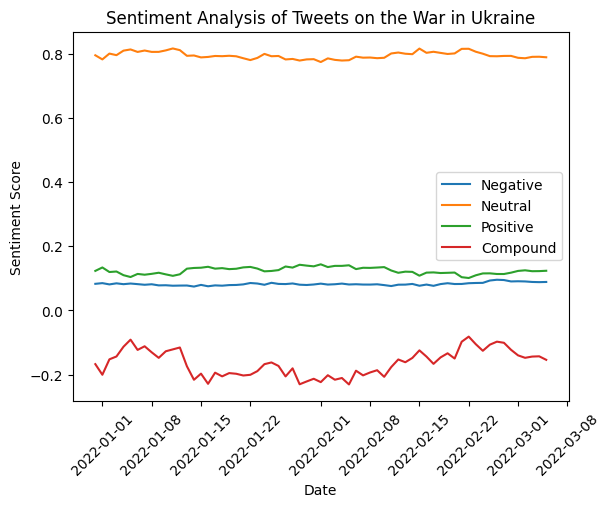

In [99]:
neg_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['pos_score'].mean()
neu_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['neu_score'].mean()
pos_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['neg_score'].mean()
compound_sentiment = data.groupby(pd.to_datetime(data['date']).dt.date)['compound_score'].mean()

plt.plot(neg_sentiment.index, neg_sentiment.values, label='Negative')
plt.plot(neu_sentiment.index, neu_sentiment.values, label='Neutral')
plt.plot(pos_sentiment.index, pos_sentiment.values, label='Positive')
plt.plot(compound_sentiment.index, compound_sentiment.values, label='Compound')

plt.title('Sentiment Analysis of Tweets on the War in Ukraine')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()

# Rotate x-tick labels by 45 degrees
plt.xticks(rotation=45)

plt.show()

In [100]:
positive = (reduced_data['compound_score'] > 0.05).sum()
negaive = (reduced_data['compound_score'] < -0.05).sum()
neutral = ((reduced_data['compound_score'] >= -0.05) & (reduced_data['compound_score'] <= 0.05)).sum()
extreme_negative = (reduced_data['compound_score'] < -0.2).sum()
print(f"Positive tweets: {positive}\nNeutral tweets: {neutral}\nNegative tweets: {negaive}\nExtreme Negative: {extreme_negative}")

Positive tweets: 238206
Neutral tweets: 112372
Negative tweets: 393223
Extreme Negative: 358811


In [101]:
loaded_data = pd.read_csv('analysed_data.csv')
loaded_data = loaded_data.dropna(subset=['cleanedTweet'])
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743801 entries, 0 to 743800
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   cleanedTweet    743801 non-null  object 
 1   neg_score       743801 non-null  float64
 2   neu_score       743801 non-null  float64
 3   pos_score       743801 non-null  float64
 4   compound_score  743801 non-null  float64
dtypes: float64(4), object(1)
memory usage: 28.4+ MB


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


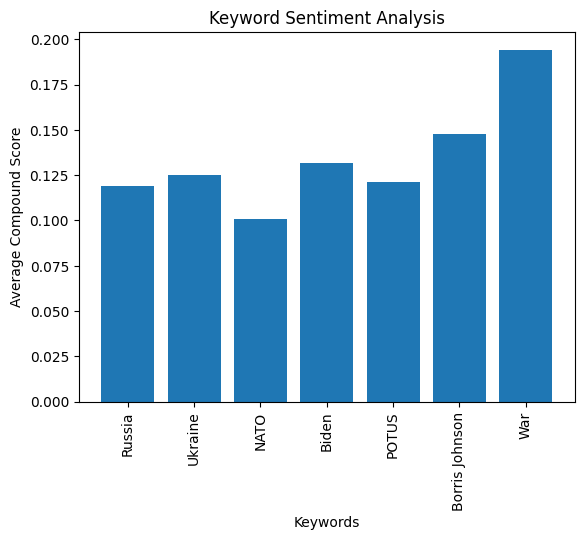

In [102]:
keywords = [
    "Russia",
    "Ukraine",
    "NATO",
    "Biden",
    "POTUS",
    "Borris Johnson",
    "War"
]
scores = {}
for word in tqdm(keywords):
    scores[word] = loaded_data[loaded_data['cleanedTweet'].str.contains(word)]['neg_score'].mean()

plt.bar(range(len(scores)), list(scores.values()), align='center')
plt.xticks(range(len(scores)), list(scores.keys()), rotation='vertical')
plt.xlabel('Keywords')
plt.ylabel('Average Compound Score')
plt.title('Keyword Sentiment Analysis')
plt.show()

In [103]:
keywords = [
    "Russia",
    "Ukraine",
    "NATO",
    "Biden",
    "POTUS",
    "Borris Johnson",
    "Putin",
    "Zelensky"
]

scores = {'neg_score': {}, 'pos_score': {}}

for word in tqdm(keywords):
    # Convert the cleaned tweet text to lowercase
    cleaned_tweet_lower = loaded_data['cleanedTweet'].str.lower()
    
    # Filter the data to rows where the lowercase cleaned tweet contains the lowercase keyword
    neg_mask = cleaned_tweet_lower.str.contains(word.lower())
    pos_mask = cleaned_tweet_lower.str.contains(word.lower())
    
    # Compute the mean negative and positive scores for the filtered data
    scores['neg_score'][word] = loaded_data.loc[neg_mask, 'neg_score'].mean()
    scores['pos_score'][word] = loaded_data.loc[pos_mask, 'pos_score'].mean()

100%|██████████| 8/8 [00:08<00:00,  1.12s/it]


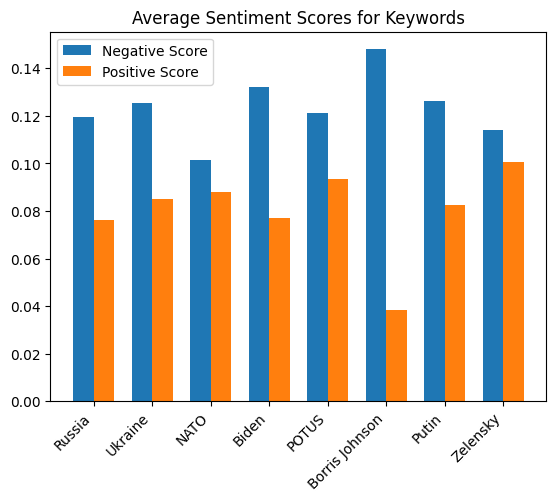

In [104]:
# Extract the negative and positive scores from the scores dictionary
neg_scores = [scores['neg_score'][word] for word in keywords]
pos_scores = [scores['pos_score'][word] for word in keywords]

# Define the x-axis positions for the bars
x_positions = np.arange(len(keywords))

# Define the width of the bars
bar_width = 0.35

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the negative and positive scores as two sets of bars
ax.bar(x_positions - bar_width/2, neg_scores, bar_width, label='Negative Score')
ax.bar(x_positions + bar_width/2, pos_scores, bar_width, label='Positive Score')

# Add x-axis labels and ticks
ax.set_xticks(x_positions)
ax.set_xticklabels(keywords, rotation=45, ha='right')

# Add a legend and a title
ax.legend()
ax.set_title('Average Sentiment Scores for Keywords')

# Show the plot
plt.show()


In [114]:
cleaned_tweet_lower = loaded_data['cleanedTweet'].str.lower()

In [121]:
matches = reduced_data[(reduced_data['compound_score'] < -0.5) & (reduced_data['cleanedTweet'].str.contains("Biden".lower(), case=False))]
print(f"{len(matches)} found")
for index, row in matches.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

21714 found
Biden hiked the price of oil so Putin could pay for the war. Biden still is buying Russian oil - paying Putin. The Ukraine gave up nuclear weapons for a border guarantee. Biden by not honoring that guarantee has shredded the Nuclear Non Proliferation treaty.	score: -0.8722
Obama/Biden literally toppled the Ukrainian government in and installed a puppet, so they could pull Ukraine away from Russia and get NATO troops on the Russian border. It was needlessly provocative, and it has led to this war.	score: -0.6833
So our gas is high because of...Trump? Inflation... Southern Border Crisis... Russian invasion of Ukraine... ...because of Trump? And Biden has nothing to do with this?	score: -0.6848
Manufactured Crisis II, Joe Bidens Ukraine-Russian Manufactured Crisis III, Joe Bidens Ukraine-Russian Manufactured Crisis IV, Joe Bidens Border Catastrophe I, Foreign News-Overseas News I, Vaccine Manufacturers Stock Prices (Follow the Money) News, Military Suppliers	score: -0.9565
Why

In [123]:
matches = reduced_data[(reduced_data['compound_score'] > 0.75) & (reduced_data['cleanedTweet'].str.contains("Biden".lower(), case=False))]
print(f"{len(matches)} found")
for index, row in matches.iterrows():
    print(f"{row['cleanedTweet']}\tscore: {row['compound_score']}")

2309 found
Hence, ever helpful, our brainchild VP says on the world stage what a great idea it is for Ukraine to join NATO while Russian troops stand at the border. BidenHarris	score: 0.8442
Breaking: trump met with two Russian Officials to come out with a plan in case Biden decide to help Ukraine defending its border. It seems that trump still has important documents that can help Putin to destabilize America!	score: 0.7574
This is all on JOE BIDEN !!! All he had to do is guarantee Ukraine would NOT become a member of NATO and allow US missiles to be placed on the Russian border ! Like Trump Did !!! These deaths are ALL on Biden !	score: 0.7627
So Joe Biden shared top secret servallence pictures, of the Russian buildup on Ukraine's border, with the CCP and asked them to help. Instead of helping Biden the Chinese shared the info with Putin. How many ways can you say LAUGHING STOCK	score: 0.9287
Really? Biden massed Russian troops on the border? Biden tried to blackmail Ukraine with his